## 1) Setup & Imports

In [25]:
import os, json, random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## 2) Config & Label Map

In [26]:
# --- Config ---
IMG_SIZE     = 224          # images will be resized to 224x224 pixels
BATCH_SIZE   = 32           # how many images you train on at once (per step)
EPOCHS       = 12           # how many full passes over the training set
LR           = 1e-3         # learning rate (how big each weight update is)
WEIGHT_DECAY = 1e-4         # L2 regularization to reduce overfitting
POOL_TYPE    = "max"        # choose pooling type: "max" or "avg" in your CNN
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # ^ use GPU (CUDA) if available, otherwise CPU
SEED         = 42           # random seed for reproducibility

random.seed(SEED); torch.manual_seed(SEED)
# ^ fix Python and PyTorch randomness so results are more repeatable

# Base directory for processed data
BASE_DIR = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits"
BASE_DATA_URL = r"C:\Users\ASUS\Documents\ann-visual-emotion"

# File paths
CSV_TRAIN = f"{BASE_DIR}\\train.csv"
CSV_VAL   = f"{BASE_DIR}\\val.csv"
CSV_TEST  = f"{BASE_DIR}\\test.csv"

# Label mapping for 8 emotions
label_map = {
    "amusement": 0, "anger": 1, "awe": 2, "contentment": 3,
    "disgust": 4, "excitement": 5, "fear": 6, "sadness": 7
}
# ^ Convert the text label in your CSV (e.g., "anger") into an integer class id.
#   Keep this consistent with your dataset’s label_map.json.

id_to_label = {v:k for k,v in label_map.items()}
# ^ Inverse dictionary: 0 -> "amusement", 1 -> "anger", … 7 -> "sadness".
#   Handy for turning model predictions (ids) back into readable labels.


## 3) Load CSVs & Quick EDA

In [27]:
# Load splits
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

display(train_df.head())
print("Train size:", len(train_df), " | Val size:", len(val_df), " | Test size:", len(test_df))

,image_path,label
0,data/raw/EmoSet/contentment/contentment_09260.jpg,contentment
1,data/raw/EmoSet/anger/anger_06224.jpg,anger
2,data/raw/EmoSet/contentment/contentment_03550.jpg,contentment
3,data/raw/EmoSet/sadness/sadness_08827.jpg,sadness
4,data/raw/EmoSet/contentment/contentment_09558.jpg,contentment


Train size: 13864  | Val size: 1734  | Test size: 1734



## 4) Dataset & Transforms

In [28]:

class EmotionDataset(Dataset):
    """Expects CSV with columns: image_path, emotion"""
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        y = label_map[row['emotion']]
        if self.transform:
            img = self.transform(img)
        return img, y

# Transforms (augmentation only for train)
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.15, 0.15, 0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = EmotionDataset(train_df, transform=train_tfms)
val_ds   = EmotionDataset(val_df,   transform=eval_tfms)
test_ds  = EmotionDataset(test_df,  transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


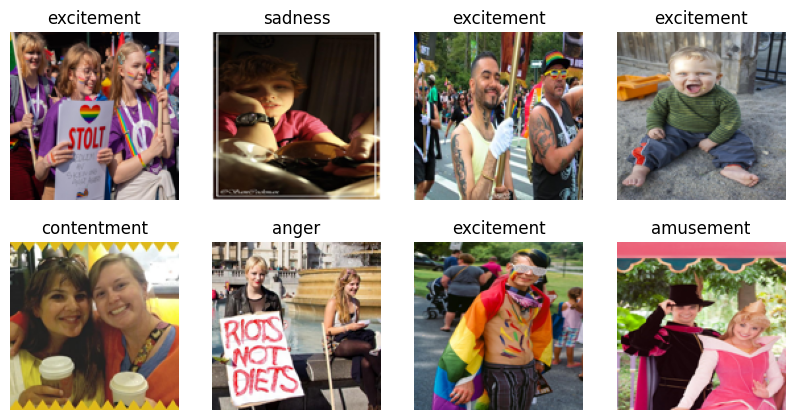

In [30]:
# This cell may need display support depending on your environment.
# It simply shows a handful of raw images (without transforms).

try:
    import random
    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    for ax in axes.ravel():
        i = random.randint(0, len(train_df)-1)
        path = f"{BASE_DATA_URL}/{train_df.iloc[i]['image_path']}"
        emotion = train_df.iloc[i]['label']
        img = Image.open(path).convert("RGB").resize((128,128))
        ax.imshow(img)
        ax.set_title(emotion)
        ax.axis('off')
    plt.show()
except Exception as e:
    print("Skipping preview (could not load images here):", e)


## 6) Define a Simple CNN (Conv → ReLU → Pool → Dense)

In [31]:

class SimpleCNN(nn.Module):
    """Three Conv blocks. Each has:
       Conv2d(kernel=3, stride=1, padding=1) -> ReLU -> Pool(2x2)
       Then Flatten -> Dense(256) -> Dropout -> Dense(8 classes)
       Padding=1 with kernel=3 keeps H,W same before pooling.
    """
    def __init__(self, pool_type="max"):
        super().__init__()
        self.conv1 = nn.Conv2d(3,   32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2,2) if pool_type=='max' else nn.AvgPool2d(2,2)

        self.conv2 = nn.Conv2d(32,  64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2,2) if pool_type=='max' else nn.AvgPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2,2) if pool_type=='max' else nn.AvgPool2d(2,2)

        # after 3 pools: 224 -> 112 -> 56 -> 28
        flattened = 128 * (IMG_SIZE//8) * (IMG_SIZE//8)  # 128*28*28

        self.fc1 = nn.Linear(flattened, 256)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, len(label_map))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool1(x)
        x = self.relu(self.conv2(x)); x = self.pool2(x)
        x = self.relu(self.conv3(x)); x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x)); x = self.drop(x)
        x = self.fc2(x)
        return x

# Quick shape check
with torch.no_grad():
    tmp = torch.zeros(1,3,IMG_SIZE,IMG_SIZE)
    m = SimpleCNN(pool_type=POOL_TYPE)
    out = m(tmp)
    print("Output logits shape:", out.shape, "(should be [1, 8])")


Output logits shape: torch.Size([1, 8]) (should be [1, 8])


## 7) Training Loop (Backpropagation)

In [32]:

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()           # 0) clear old gradients
        logits = model(images)          # 1) forward
        loss = criterion(logits, labels)# 2) compute loss
        loss.backward()                 # 3) backprop (compute gradients)
        optimizer.step()                # 4) update weights

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        running_correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss/total, running_correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        running_correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss/total, running_correct/total

## 8) Fit the Model (Train + Validate)

In [ ]:

model = SimpleCNN(pool_type=POOL_TYPE).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val_acc = 0.0
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} acc {tr_acc:.4f} || val_loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "checkpoints/simple_cnn_best.pt")
        print("  -> saved best checkpoint")

c:\Users\ASUS\Documents\ann-visual-emotion\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [2]:
import torch, platform

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  # Apple Silicon / Metal
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)


Device: cpu


In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


PyTorch version: 2.8.0+cpu
CUDA available: False
CUDA device count: 0
GPU name: None
